In [2]:
#!pip install keras

In [3]:
!pip install tensorflow

In [1]:
# import libraries
import json
import math
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import cv2  # image processing
import numpy as np  # linear algebra
import pandas as pd  # data processing
import matplotlib.pyplot as plt  # data visualization

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Verify TensorFlow version (optional)
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.15.0


In [4]:
#Upload Kaggle API Token to Colab - kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sravaninemala","key":"dd51e3e2aebfbe57d0acb4f16b1eaa94"}'}

In [5]:
#Move Kaggle API Token to the Appropriate Location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#install Kaggle package
!pip install kaggle

In [14]:
#unzip dataset
!unzip chest-xray-pneumonia.zip -d ./dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./dataset/chest_xray/train/NORMAL/IM-044

In [13]:
# Download Dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
# Load Data sets
input_dir = "/content/dataset/chest_xray/chest_xray/"
train_dir = input_dir + "train"
test_dir = input_dir + "test"
val_dir = input_dir + "val"

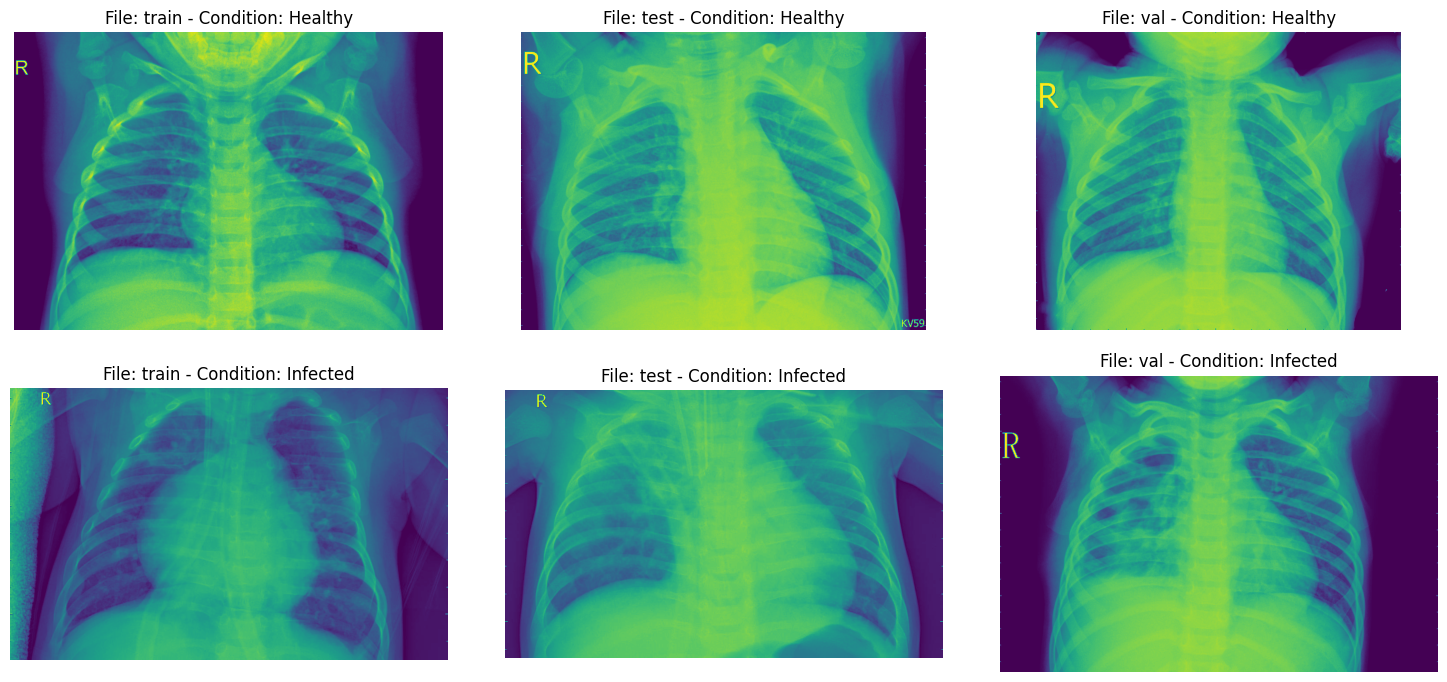

In [16]:
# Create a figure with subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

# Iterate over the train, test, and val sets
for i, _set in enumerate(['train', 'test', 'val']):
    set_path = os.path.join(input_dir, _set)

    # Plot images for the 'NORMAL' condition
    normal_image_path = os.path.join(set_path, 'NORMAL', os.listdir(os.path.join(set_path, 'NORMAL'))[0])
    ax[i].axis('off')
    ax[i].imshow(plt.imread(normal_image_path))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))

    # Plot images for the 'PNEUMONIA' condition
    pneumonia_image_path = os.path.join(set_path, 'PNEUMONIA', os.listdir(os.path.join(set_path, 'PNEUMONIA'))[0])
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(pneumonia_image_path))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

# Show the plots
plt.show()


In [17]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
# Create DenseNet201 Model with Keras library

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['acc']
    )
    return model

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(densenet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18331585 (69.93 MB)
Trainable params: 1809

In [19]:
# Fit Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_data=test_generator,
    validation_steps=10
)

<ipython-input-19-573887ad5236>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
100/100 [==============================] - 165s 425ms/step - loss: 0.3774 - acc: 0.8530 - val_loss: 74.4955 - val_acc: 0.5850
Epoch 2/25
100/100 [==============================] - 39s 390ms/step - loss: 0.3036 - acc: 0.8720 - val_loss: 1.7602 - val_acc: 0.6200
Epoch 3/25
100/100 [==============================] - 51s 509ms/step - loss: 0.1972 - acc: 0.9269 - val_loss: 0.7457 - val_acc: 0.6150
Epoch 4/25
100/100 [==============================] - 39s 389ms/step - loss: 0.1939 - acc: 0.9218 - val_loss: 0.7670 - val_acc: 0.6950
Epoch 5/25
100/100 [==============================] - 40s 394ms/step - loss: 0.1984 - acc: 0.9223 - val_loss: 1.3729 - val_acc: 0.6600
Epoch 6/25
100/100 [==============================] - 40s 401ms/step - loss: 0.2041 - acc: 0.9228 - val_loss: 2.4163 - val_acc: 0.5450
Epoch 7/25
100/100 [==============================] - 39s 386ms/step - loss: 0.1845 - acc: 0.9265 - val_loss: 0.4596 - val_acc: 0.8150
Epoch 8/25
100/100 [==============================] -

In [20]:
# model save
model.save_weights("cnn-example-pneumonia-densenet201.h5")

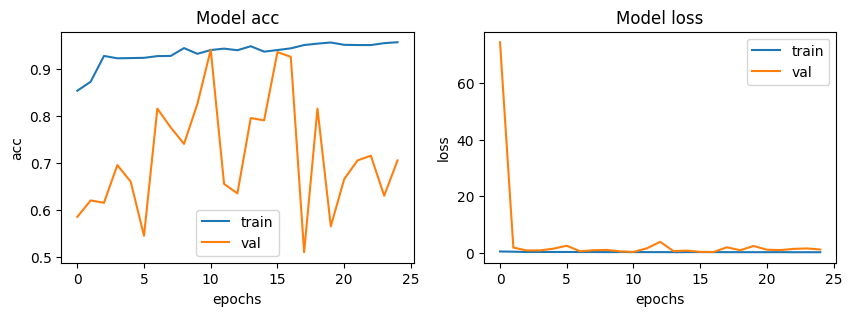

In [21]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.show()